<a href="https://colab.research.google.com/github/mduffy23/Sarcasm-Detection-AIML-Final-Project/blob/main/Sarcasm_Detection_Final_Project_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Sarcasm Detection

There is a common experience amoung people of reading a text and not being sure if it is supposed to be sarcastic or not (or even being on the reverse, trying to text and make sure the other person knows you are being sarcastic). It is a bit awkward and difficult to interpret without inflection that one usually uses when saying something sarcastic.

This project aims to generate a model that can predict of a statement is sarcastic or not, purely based on the text used. Capitalization, punctuation, and word choice can all help indicate whether or not the writer of a comment meant to express the statement sarcastically.

- The baseline model if TFID.
- The final model is a fine tuned RoBERTA model.

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Final AIML Project - Sarcasm Detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install -q transformers datasets accelerate sentencepiece
#!pip install -q torch --index-url https://download.pytorch.org/whl/cu121
#!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from datasets import Dataset, ClassLabel, Features
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
import torch
import torch.nn as nn
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaModel,
    TrainingArguments,
    Trainer,
    default_data_collator
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
import optuna

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Dataset

Dataset comes from https://www.kaggle.com/datasets/danofer/sarcasm. The dataset was downloaded via kaggle hub on my local machine and moved into google drive for easy access. This dataset contains 1,010,826 comments from Reddit, balanced between not sarcastic and sarcastic comments. The sarcasm data was generated by scraping comments containing a sarcasm tag.

I initally planned to use a headline sarcasm dataset, but this was insufficient because the *sarcastic* comments did not relfect the sarcasm used by people in conversation. The idea behind this project is that one could get a text out of no where (or in the midst of chat) and get a reasonable prediction of the text they are reading is sarcastic or not. Reddit was a far better alternative to capture sarcasm that people utilzie.

In [4]:
sarcasm = pd.read_csv(project_path + '/train-balanced-sarcasm.csv')
print(sarcasm.info())
display(sarcasm.head())
display(pd.DataFrame(sarcasm['label'].value_counts().reset_index().rename(columns={'index': 'label', 'label': 'count'})))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB
None


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


,count,count
0,0,505413
1,1,505413


In [5]:
display(sarcasm.isna().sum())
sarcasm.dropna(inplace=True)

,0
label,0
comment,55
author,0
subreddit,0
score,0
ups,0
downs,0
date,0
created_utc,0
parent_comment,0


Must drop any null comments.

In [6]:
sarcasm['subreddit'].value_counts().head(20)

,count
subreddit,
AskReddit,65674
politics,39493
worldnews,26375
leagueoflegends,21034
pcmasterrace,18987
funny,17939
news,16891
pics,16152
todayilearned,14159


There are many different *subreddits* that are specific to particular topics. The most common is a very generic subreddit called "AskReddit" which is followed by more specific domains like politics and worldnews.

One important consideration for this project is the lack of context the model gets. The "AskReddit" subreddit poses questions that are answered by people. Sometimes the answers are sarcastic, but one would only know that based on the question at hand. Perhaps putting in a feature for parent comment would help with the association of more contextual sarcasm, but I want to focus more on catching sarcasm that comes out of the blue. Not using any parent comment for context should help the model understand the essence of sarcasm, rather than how to respond to someone sarcastically. Maybe a sarcasm generation model would be better suited to use a parent comment for a training feature.

Taking a fairly large sample of the data and then splitting it into X and y.

In [7]:
sample_sarcasm, _ = train_test_split(sarcasm, train_size=0.75, random_state=102, stratify=sarcasm['label'])
sample_sarcasm.reset_index(drop=True, inplace=True)
sample_sarcasm.shape

(758078, 10)

In [8]:
X = sample_sarcasm['comment']
y = sample_sarcasm['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102, stratify=y)

## Text Processing

### Sarcasm Indications

I want the model to learn sarcasm from training on the Reddit comments, but I also want to help it along by identifying common indicators of sarcasm. I created function to add a lexical sarcasm feature to any string of text. This will be used as a secondary variable in both the baseline and final models.

In [9]:
intensifiers = {'literally', 'totally', 'completely', 'absolutely', 'seriously', 'really', 'just' 'sooo', 'wooow'}
irony = {'yeah right', 'oh great', 'just perfect', 'of course', 'sure thing', 'oh yeah', 'oh,'}
sarcasm_punctuation = {'!', '!!', '!?', '?!'}

In [10]:
def count_elongated(token):
    return 1 if re.search(r"(.)\1\1+", token) else 0

def lexical_features_one(text):
    text_lower = text.lower()
    tokens = re.findall(r'\w+|\S', text)

    intensifier_count = sum(t.lower() in intensifiers for t in tokens)

    irony_present = 1 if any(phrase in text_lower for phrase in irony) else 0

    punctuation_count = sum(text.count(p) for p in sarcasm_punctuation)

    cap_tokens = sum(1 for t in tokens if len(t) > 2 and t.isupper())
    cap_ratio = cap_tokens / max(len(tokens), 1)

    elongated_count = sum(count_elongated(t) for t in tokens)

    return [
        intensifier_count,
        irony_present,
        punctuation_count,
        cap_ratio,
        elongated_count
    ]

def build_lexical_matrix(text_list):
    return np.vstack([lexical_features_one(t) for t in text_list])

### Lemmatizer

This is for TFID, not RoBerta. A transformer model like RoBerta...

In [11]:
# Lemmatize functions

## For Modelling
def sarcasm_lemma_tokenizer(text):
  lemmatizer = WordNetLemmatizer()
  text = text.lower()
  tokens = word_tokenize(text)
  lemmas = [lemmatizer.lemmatize(tok) if tok.isalpha() else tok for tok in tokens]
  return lemmas

## For visuals
def sarcasm_lemma_vectorizer_no_punc(text):
  tokens = sarcasm_lemma_tokenizer(text)
  return [tok.lower() for tok in tokens if tok.isalpha() and tok not in sarcasm_punctuation]


## Data Exploration

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


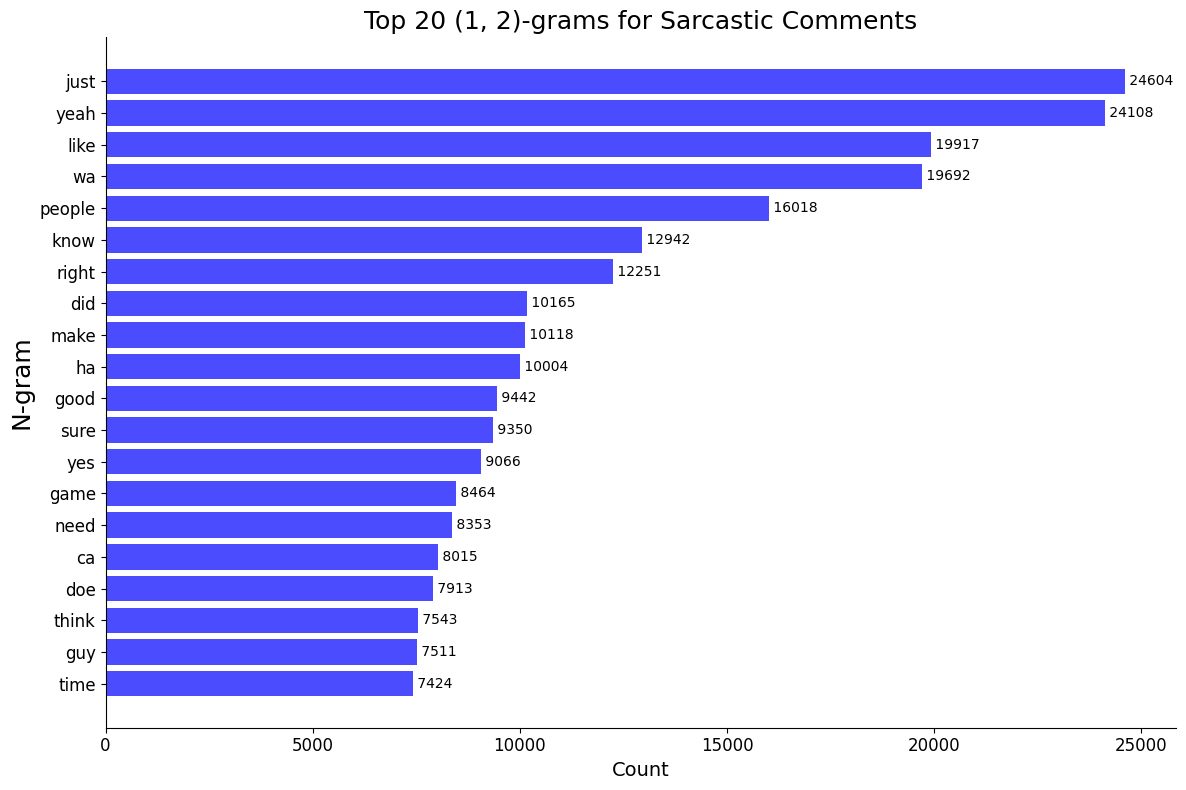

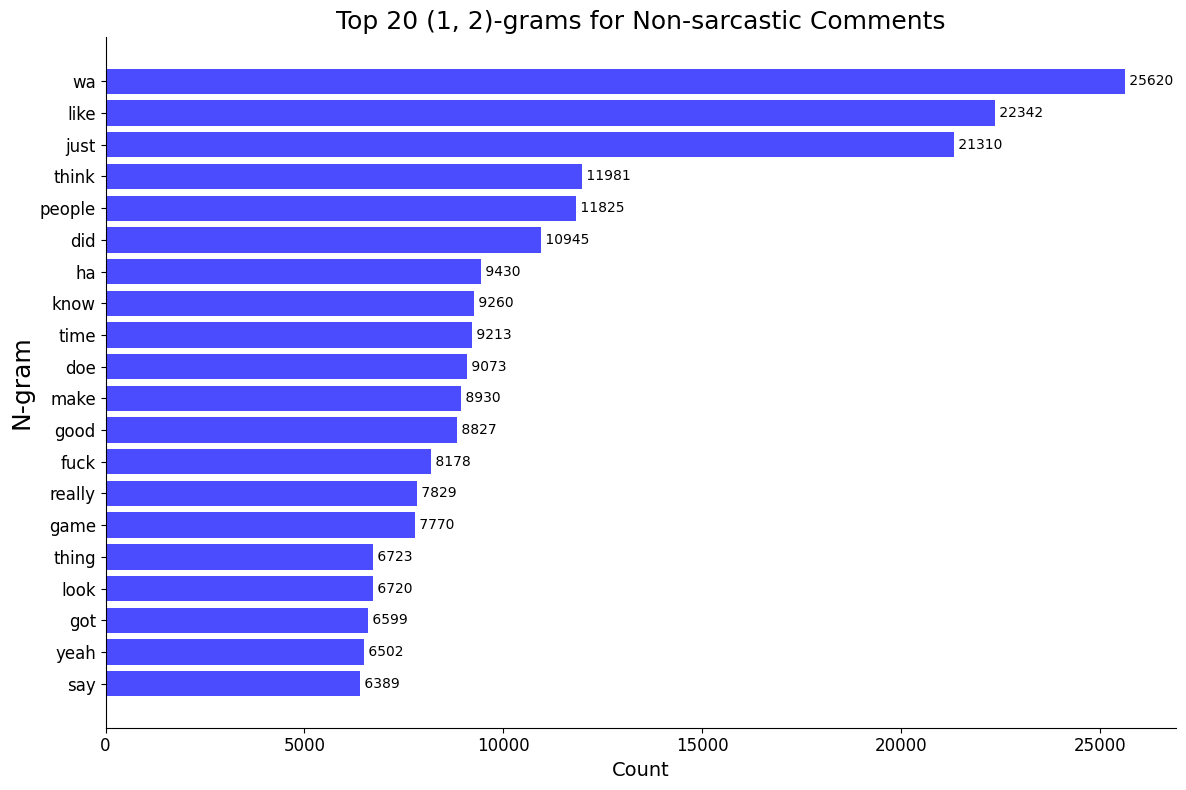

In [12]:
def plot_top_grams(df, label_val, n_gram_range = (1, 2), top=20):
  df_label = df[df['label'] == label_val]['comment']
  vectorizer = CountVectorizer(tokenizer=sarcasm_lemma_vectorizer_no_punc, token_pattern=None, lowercase=True, ngram_range=n_gram_range, stop_words='english')
  X = vectorizer.fit_transform(df_label)

  counts = np.asarray(X.sum(axis=0)).flatten()
  vocab = vectorizer.get_feature_names_out()

  freq_df = pd.DataFrame({'ngram': vocab, 'count': counts})
  freq_df = freq_df.sort_values(by='count', ascending=False).head(top)

  plt.figure(figsize=(12, 8))
  bars = plt.barh(freq_df['ngram'], freq_df['count'], color='blue', alpha = 0.7)
  plt.gca().invert_yaxis() # Show highest frequency on top
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('Count', fontsize=14)
  plt.ylabel('N-gram', fontsize=18)
  plt.title(f'Top {top} {n_gram_range}-grams for {'Sarcastic' if label_val == 1 else 'Non-sarcastic'} Comments', fontsize=18)

  # Add data labels
  for bar in bars:
      plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {int(bar.get_width())}', va='center')

  plt.tight_layout()
  sns.despine()
  plt.show()

plot_top_grams(sample_sarcasm, 1)
plot_top_grams(sample_sarcasm, 0)

## Baseline TF-IDF

In [13]:
# Define a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102, stratify=y)

In [14]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(tokenizer=sarcasm_lemma_tokenizer, ngram_range=(1, 2), min_df=2, preprocessor=None, token_pattern=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [15]:
# Add lexical features
X_train_lex = build_lexical_matrix(X_train)
X_test_lex = build_lexical_matrix(X_test)

# Add to dataset
X_train = hstack([X_train_vec, X_train_lex])
X_test = hstack([X_test_vec, X_test_lex])

In [16]:
# Linear classifier
clf = LogisticRegression(max_iter=500, class_weight = 'balanced')
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75     75811
           1       0.75      0.71      0.73     75805

    accuracy                           0.74    151616
   macro avg       0.74      0.74      0.74    151616
weighted avg       0.74      0.74      0.74    151616

[[58427 17384]
 [22267 53538]]


Simple logisitic regression does a nice job on generally learning sarcasm (significantly better than guessing).

## BERT

In [77]:
dataset = Dataset.from_dict({"text": X, "label": y})
features = Features({"text": dataset.features["text"], "label": ClassLabel(num_classes=2, names=[0, 1])})
dataset = dataset.cast(features)
dataset = dataset.train_test_split(test_size=0.20, seed=102, stratify_by_column='label')

Casting the dataset:   0%|          | 0/94509 [00:00<?, ? examples/s]

In [53]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

def add_lexical_features(batch):
    features = [lexical_features_one(text) for text in batch['text']]
    batch['lexical_features'] = features
    return batch

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.map(add_lexical_features, batched=True)
tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")

Map:   0%|          | 0/75607 [00:00<?, ? examples/s]

Map:   0%|          | 0/18902 [00:00<?, ? examples/s]

In [55]:
training_args = TrainingArguments(
    output_dir= project_path + "/test",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"]
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.737600,0.694966
2,0.720600,0.728677


Epoch,Training Loss,Validation Loss
1,0.737600,0.694966
2,0.720600,0.728677
3,0.698100,0.693094


TrainOutput(global_step=14178, training_loss=0.7227166356514397, metrics={'train_runtime': 9601.7794, 'train_samples_per_second': 23.623, 'train_steps_per_second': 1.477, 'total_flos': 5.967911268781056e+16, 'train_loss': 0.7227166356514397, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

In [56]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

sentences = ['Great work, no one has ever thought of that.']

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

probs = torch.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1)

print(probs)
print(preds)

tensor([[0.4887, 0.5113]], device='cuda:0')
tensor([1], device='cuda:0')


In [57]:
outputs = trainer.predict(tokenized["test"])

In [58]:
outputs = trainer.predict(tokenized["test"])
logits = outputs.predictions
labels = outputs.label_ids
preds = np.argmax(logits, axis=1)
print(classification_report(labels, preds))
print(confusion_matrix(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9322
           1       0.51      1.00      0.67      9580

    accuracy                           0.51     18902
   macro avg       0.25      0.50      0.34     18902
weighted avg       0.26      0.51      0.34     18902

[[   0 9322]
 [   0 9580]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
model.save_pretrained(project_path + '/withsarcasmref')

In [32]:
tokenizer.save_pretrained(project_path + '/withsarcasmref')

('/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/withsarcasmref/tokenizer_config.json',
 '/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/withsarcasmref/special_tokens_map.json',
 '/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/withsarcasmref/vocab.txt',
 '/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/withsarcasmref/added_tokens.json')

In [ ]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [ ]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        return_tensors=None
    )

def add_lexical_features(batch):
    batch["lexical_features"] = [
        lexical_features_one(text) for text in batch["text"]
    ]
    return batch

# cast labels
features = Features({
    "text": dataset.features["text"],
    "label": ClassLabel(num_classes=2),
})
dataset = dataset.cast(features)

# train-test split
dataset = dataset.train_test_split(
    test_size=0.20,
    seed=102,
    stratify_by_column="label"
)

# Apply tokenizer + lexical features
tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.map(add_lexical_features, batched=True)

# remove unused columns
tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.rename_column("label", "labels")

# Convert everything to PyTorch tensors
tokenized.set_format("torch")

In [78]:
import torch
import torch.nn as nn
from transformers import RobertaModel, RobertaConfig

class RobertaWithFeatures(nn.Module):
    def __init__(self, feature_dim, num_labels=2):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(0.1)

        # The CLS embedding is 768-dimensional for roberta-base
        roberta_dim = self.roberta.config.hidden_size

        # Combine CLS + custom feature vector
        combined_dim = roberta_dim + feature_dim

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, features):
        # RoBERTa forward
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token

        # Concatenate CLS with custom lexical features
        combined = torch.cat([cls_emb, features], dim=1)
        logits = self.classifier(combined)
        return logits

model = RobertaWithFeatures(feature_dim=5)

class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, labels):
        self.encodings = encodings
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["features"] = self.features[idx]
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
from transformers import Trainer
import torch.nn as nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        lexical_features = inputs["lexical_features"]

        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            lexical_features=lexical_features
        )

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(outputs, labels)

        return (loss, outputs) if return_outputs else loss

In [75]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        features = inputs.pop("features")
        outputs = model(**inputs, features=features)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir= project_path + "/results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
)

trainer.train()

##RoBERTa

In [17]:
# Utilize GPU well
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("medium")

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [31]:
# Model defintion with Lexical Features
class RobertaWithLexical(nn.Module):
    def __init__(self, model_name="roberta-base", feature_dim=5, num_labels=2, dropout=0.1):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        hidden_size = self.roberta.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size + feature_dim, num_labels)

    def forward(self, input_ids=None, attention_mask=None, lexical_features=None, labels=None, **kwargs):
        # Roberta embeddings
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token

        # Lexical features
        if lexical_features is None:
            lexical_features = torch.zeros(cls_emb.size(0), 0, device=cls_emb.device, dtype=cls_emb.dtype)
        else:
            lexical_features = lexical_features.to(cls_emb.device)
            if lexical_features.dtype != cls_emb.dtype:
                lexical_features = lexical_features.to(dtype=cls_emb.dtype)

        # Concatenate
        combined = torch.cat([cls_emb, lexical_features], dim=1)
        pooled = self.dropout(combined)
        logits = self.classifier(pooled)

        # Compute loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        # Return proper HF output
        return SequenceClassifierOutput(loss=loss, logits=logits)

In [19]:
# Lexical feature generation
intensifiers = {"literally", "absolutely", "totally", "completely", "seriously"}
irony = {"yeah right", "sure", "as if", "i bet", "no way", "oh great", "oh yeah"}
sarcasm_punctuation = {"!","!!","!?","?!"}

def count_elongated(token):
    return 1 if re.search(r"(.)\1\1+", token) else 0

def lexical_features_one(text):
    text = str(text)
    text_lower = text.lower()
    tokens = re.findall(r'\w+|\S', text)

    intensifier_count = sum(t.lower() in intensifiers for t in tokens)
    irony_present = 1 if any(phrase in text_lower for phrase in irony) else 0
    punctuation_count = sum(text.count(p) for p in sarcasm_punctuation)
    cap_tokens = sum(1 for t in tokens if len(t) > 2 and t.isupper())
    cap_ratio = cap_tokens / max(len(tokens), 1)
    elongated_count = sum(count_elongated(t) for t in tokens)

    return [intensifier_count, irony_present, punctuation_count, cap_ratio, elongated_count]

In [20]:
# Data set up
MODEL_NAME = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

X = sample_sarcasm['comment'].tolist()
y = sample_sarcasm['label'].tolist()

def add_lexical(batch):
    batch["lexical_features"] = [np.array(lexical_features_one(x), dtype=np.float32) for x in batch["text"]]
    return batch

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

dataset = Dataset.from_dict({"text": X, "labels": y})
dataset = dataset.train_test_split(test_size=0.2, seed=102)

dataset = dataset.map(add_lexical, batched=True)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "lexical_features", "labels"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/606462 [00:00<?, ? examples/s]

Map:   0%|          | 0/151616 [00:00<?, ? examples/s]

Map:   0%|          | 0/606462 [00:00<?, ? examples/s]

Map:   0%|          | 0/151616 [00:00<?, ? examples/s]

We used a train test split here since we are using a lot of data to train. Training loops (even using Colab Pro GPUs) can take 20-30 minutes for one model. Using cross validation would multiply that 5x, which is just too exspensive and time consuming for the resources available.

In [21]:
# Training helpers

## Freeze
def freeze_roberta(model, train_last_n=4):
    total = model.roberta.config.num_hidden_layers
    train_from = total - train_last_n

    for name, param in model.roberta.named_parameters():
        match = re.search(r"encoder\.layer\.(\d+)\.", name)
        if match:
            layer = int(match.group(1))
            if layer < train_from:
                param.requires_grad = False
        elif "embeddings" in name:
            param.requires_grad = False

## Training Metrics
def metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds)
    }

In [18]:
# Training helpers

# Freeze
def freeze_roberta(model, train_last_n=4):
    total = model.roberta.config.num_hidden_layers
    train_from = total - train_last_n

    for name, param in model.roberta.named_parameters():
        match = re.search(r"encoder\.layer\.(\d+)\.", name)
        if match:
            layer = int(match.group(1))
            if layer < train_from:
                param.requires_grad = False
        elif "embeddings" in name:
            param.requires_grad = False

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        lexical = inputs.pop("lexical_features")

        outputs = model(
            **inputs,
            lexical_features=lexical,
            labels=labels,
            **kwargs
        )

        loss = outputs.loss

        return (loss, outputs) if return_outputs else loss

def metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds)
    }

#Good
# ==============================================================
# 6. TRAINING
# ==============================================================

model = RobertaWithLexical()
freeze_roberta(model, train_last_n=4)

# Try compile()
try:
    model = torch.compile(model)
    print("Compiled model for faster training.")
except Exception as e:
    print("torch.compile failed:", e)

#training_args = TrainingArguments(
#    output_dir="/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/RobertaLarge",
#    per_device_train_batch_size=32,
#    per_device_eval_batch_size=64,
#    eval_strategy="epoch",
#    save_strategy="epoch",
#    remove_unused_columns=False,
#    fp16=True,
#    optim="adamw_torch_fused",
#    learning_rate=3e-5,
#    num_train_epochs=3,
#    dataloader_num_workers=4,
#    dataloader_pin_memory=True,
#    dataloader_persistent_workers=True,
#    report_to="none"
#)

#trainer = Trainer(
#    model=model,
#    args=training_args,
#    train_dataset=dataset["train"],
#    eval_dataset=dataset["test"],
#    tokenizer=tokenizer,
#    data_collator=default_data_collator,
#    compute_metrics=metrics,
#)


#trainer.train()
#trainer.save_model("/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/RobertaLarge")

Map:   0%|          | 0/606462 [00:00<?, ? examples/s]

Map:   0%|          | 0/151616 [00:00<?, ? examples/s]

Map:   0%|          | 0/606462 [00:00<?, ? examples/s]

Map:   0%|          | 0/151616 [00:00<?, ? examples/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1187598400.py:240: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Compiled model for faster training.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-12-06 16:06:51,432] A new study created in memory with name: no-name-3209b25c-aa21-4908-a22d-d1258f8cc1a1


TypeError: create_study() got an unexpected keyword argument 'study'

In [22]:
# Optuna Helpers
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 6e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.2),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2)
    }

def model_init(trial=None):
    dropout = 0.1
    train_last_n = 4

    # If Optuna trial is active, override the defaults
    if trial is not None:
        dropout = trial.suggest_float("classifier_dropout", 0.05, 0.4)
        train_last_n = trial.suggest_int("train_last_n", 1, 6)

    model = RobertaWithLexical(dropout=dropout)

    freeze_roberta(model, train_last_n=train_last_n)

    return model

In [19]:
# Hyperparameter tuning - Ran for over an hour
training_args = TrainingArguments(
    output_dir="optuna_roberta_fast",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    warmup_ratio=0.0,        # overwritten by optuna
    learning_rate=2e-5,      # overwritten by optuna
    weight_decay=0.0,        # overwritten
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="no",
    fp16=True,
    optim="adamw_torch_fused",
    report_to="none",
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=metrics,
)

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=0)
)

best_trial = trainer.hyperparameter_search(
    n_trials=10,                     # fast
    hp_space=optuna_hp_space,
    backend="optuna",
    direction="maximize",
    compute_objective=lambda m: m["eval_f1"],   # F1 target
)

print(best_trial)

/tmp/ipython-input-376830900.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-12-06 16:08:46,403] A new study created in memory with name: no-name-5977f1bd-9380-4b9e-bcf3-9ed2b3bd934d
[I 2025-12-06 16:08:46,404] A new study created in memory with name: no-name-2fab36a6-d53f-4685-bdc3-7a55fe12111a
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.522052,0.736453,0.727044


[I 2025-12-06 16:16:13,460] Trial 0 finished with value: 0.7270441970079924 and parameters: {'learning_rate': 2.6268936860815925e-05, 'weight_decay': 0.1223772405737098, 'warmup_ratio': 0.1367986076497086, 'classifier_dropout': 0.3503819012449956, 'train_last_n': 1}. Best is trial 0 with value: 0.7270441970079924.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.542109,0.723664,0.717059


[I 2025-12-06 16:25:13,135] Trial 1 finished with value: 0.7170593677613674 and parameters: {'learning_rate': 2.4710450208705864e-06, 'weight_decay': 0.15508189715475879, 'warmup_ratio': 0.06251393048829264, 'classifier_dropout': 0.0884661230113222, 'train_last_n': 2}. Best is trial 0 with value: 0.7270441970079924.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.487169,0.763409,0.757318


[I 2025-12-06 16:34:54,183] Trial 2 finished with value: 0.7573184675024186 and parameters: {'learning_rate': 2.295232455089152e-05, 'weight_decay': 0.18599655685598654, 'warmup_ratio': 0.19077011707794123, 'classifier_dropout': 0.12419861553569717, 'train_last_n': 3}. Best is trial 2 with value: 0.7573184675024186.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.520615,0.739961,0.732538


[I 2025-12-06 16:43:14,105] Trial 3 finished with value: 0.732538261152719 and parameters: {'learning_rate': 6.472767895346402e-06, 'weight_decay': 0.04912972178883948, 'warmup_ratio': 0.17153761887165359, 'classifier_dropout': 0.18145853383509408, 'train_last_n': 2}. Best is trial 2 with value: 0.7573184675024186.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.480561,0.767683,0.761651


[I 2025-12-06 16:52:29,975] Trial 4 finished with value: 0.7616508434892644 and parameters: {'learning_rate': 2.485002246616929e-05, 'weight_decay': 0.1802756018668522, 'warmup_ratio': 0.018819509939976123, 'classifier_dropout': 0.16749163342760462, 'train_last_n': 4}. Best is trial 4 with value: 0.7616508434892644.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.512475,0.744071,0.734776


[I 2025-12-06 16:59:48,589] Trial 5 finished with value: 0.7347764570788022 and parameters: {'learning_rate': 4.7758299451694336e-05, 'weight_decay': 0.0712452619903812, 'warmup_ratio': 0.04480761080016187, 'classifier_dropout': 0.1528048880399563, 'train_last_n': 1}. Best is trial 4 with value: 0.7616508434892644.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.568538,0.703475,0.692960


[I 2025-12-06 17:07:08,173] Trial 6 pruned. 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.490110,0.760329,0.752954


[I 2025-12-06 17:17:07,624] Trial 7 finished with value: 0.7529539737575633 and parameters: {'learning_rate': 9.626046185549841e-06, 'weight_decay': 0.11078144427336921, 'warmup_ratio': 0.1888209544415529, 'classifier_dropout': 0.2642191532370242, 'train_last_n': 5}. Best is trial 4 with value: 0.7616508434892644.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.534602,0.729125,0.720191


[I 2025-12-06 17:25:15,583] Trial 8 pruned. 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.526778,0.735688,0.725216


[I 2025-12-06 17:34:06,320] Trial 9 pruned. 


BestRun(run_id='4', objective=0.7616508434892644, hyperparameters={'learning_rate': 2.485002246616929e-05, 'weight_decay': 0.1802756018668522, 'warmup_ratio': 0.018819509939976123, 'classifier_dropout': 0.16749163342760462, 'train_last_n': 4}, run_summary=None)


In [23]:
besthyperparameters={'learning_rate': 2.485002246616929e-05, 'weight_decay': 0.1802756018668522, 'warmup_ratio': 0.018819509939976123, 'classifier_dropout': 0.16749163342760462, 'train_last_n': 4}

In [34]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids

    # argmax over classes
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )

    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [33]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'lexical_features', 'input_ids', 'attention_mask'],
        num_rows: 606462
    })
    test: Dataset({
        features: ['labels', 'lexical_features', 'input_ids', 'attention_mask'],
        num_rows: 151616
    })
})

In [36]:
# Utilize best parameters
best = besthyperparameters # best_trial.hyperparameters
model = RobertaWithLexical(dropout=best["classifier_dropout"])
freeze_roberta(model, train_last_n=best["train_last_n"])

# Try to compile for speed
try:
    model = torch.compile(model)
    print("Compiled model for faster training.")
except Exception as e:
    print("torch.compile failed:", e)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/HypertunedRoBerta/training",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    fp16=True,
    optim="adamw_torch_fused",
    learning_rate=best["learning_rate"],
    warmup_ratio=best["warmup_ratio"],
    weight_decay=best["weight_decay"],
    num_train_epochs=3,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_persistent_workers=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/HypertunedRoBerta/saved")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1116719183.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Compiled model for faster training.


Epoch,Training Loss,Validation Loss
1,0.488700,No log
2,0.466300,No log
3,0.435200,No log


In [37]:
preds_output = trainer.predict(dataset["test"])

logits = preds_output.predictions[1]        # shape: (num_samples, 2)
preds = np.argmax(logits, axis=1)           # predicted classes: 0 or 1
labels = dataset["test"]["labels"]          # Get true labels directly from the dataset

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds))
print("Confusion matrix:\n", confusion_matrix(labels, preds))
print(classification_report(labels, preds))

Accuracy: 0.7780511291684254
F1: 0.7758826232608942
Confusion matrix:
 [[59716 15725]
 [17926 58249]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     75441
           1       0.79      0.76      0.78     76175

    accuracy                           0.78    151616
   macro avg       0.78      0.78      0.78    151616
weighted avg       0.78      0.78      0.78    151616



In [38]:
def predict_sarcasm(model, text, tokenizer=tokenizer, device=None):
    model.eval()
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if isinstance(text, str):
        texts = [text]
    else:
        texts = text

    # Tokenize
    encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

    # Lexical features
    lexical_features = torch.tensor([lexical_features_one(t) for t in texts], dtype=torch.float32)

    # Move to device
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    lexical_features = lexical_features.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        lexical_features=lexical_features)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

    # Return single prediction if input was a string
    if isinstance(text, str):
        return {"predicted_label": int(preds[0]), "probabilities": probs[0]}
    else:
        return [{"predicted_label": int(p), "probabilities": prob} for p, prob in zip(preds, probs)]

statement = "Thank you for taking your sweet time on this!"

result = predict_sarcasm(model, statement)
print("Predicted label:", result["predicted_label"])  # 0 = not sarcastic, 1 = sarcastic
print("Probabilities:", result["probabilities"])

Predicted label: 0
Probabilities: [0.9293122  0.07068779]


In [39]:
statements = [
    # Obvious sarcasm
    "Oh great, another Monday morning… just what I needed!",
    "I absolutely love it when my phone dies in the middle of an important call.",
    "Sure, I’d love to do more paperwork instead of going home early.",
    "Yeah right, because traffic is exactly what I was hoping for today.",
    "I totally enjoy waking up to the sound of my neighbor’s dog at 5 AM.",

    # Mild sarcasm
    "Wow, that movie was really… interesting.",
    "I’m so glad it’s raining again, just perfect for a picnic.",
    "Oh sure, because staying late at work is my favorite hobby.",

    # Neutral / serious
    "I had a sandwich for lunch.",
    "The sky is blue today.",
    "I am going to the grocery store after work.",
    "She won the award for best performance."
]

statement_results = []
results = predict_sarcasm(model, statements)
for r, s in zip(results, statements):
    statement_results.append({'Statement' : s, 'Is_Sarcastic' : r['predicted_label'] == 1})
display(pd.DataFrame(statement_results))

W1206 20:48:19.924000 77300 torch/fx/experimental/symbolic_shapes.py:6833] [1/4] _maybe_guard_rel() was called on non-relation expression Eq(s43, 1) | Eq(s72, s43)


,Statement,Is_Sarcastic
0,"Oh great, another Monday morning… just what I ...",True
1,I absolutely love it when my phone dies in the...,True
2,"Sure, I’d love to do more paperwork instead of...",False
3,"Yeah right, because traffic is exactly what I ...",True
4,I totally enjoy waking up to the sound of my n...,True
5,"Wow, that movie was really… interesting.",False
6,"I’m so glad it’s raining again, just perfect f...",True
7,"Oh sure, because staying late at work is my fa...",True
8,I had a sandwich for lunch.,False
9,The sky is blue today.,False


In [40]:
statements_tfidf_vec = vectorizer.transform(statements)
statements_lex_features = build_lexical_matrix(statements)

statements_combined_features = hstack([statements_tfidf_vec, statements_lex_features])

tfidf_predictions = clf.predict(statements_combined_features)

# Create a DataFrame to display the results
tfidf_results = []
for s, pred in zip(statements, tfidf_predictions):
    tfidf_results.append({'Statement': s, 'Is_Sarcastic': bool(pred)})

display(pd.DataFrame(tfidf_results))

,Statement,Is_Sarcastic
0,"Oh great, another Monday morning… just what I ...",True
1,I absolutely love it when my phone dies in the...,False
2,"Sure, I’d love to do more paperwork instead of...",True
3,"Yeah right, because traffic is exactly what I ...",True
4,I totally enjoy waking up to the sound of my n...,False
5,"Wow, that movie was really… interesting.",False
6,"I’m so glad it’s raining again, just perfect f...",False
7,"Oh sure, because staying late at work is my fa...",True
8,I had a sandwich for lunch.,False
9,The sky is blue today.,False


Seems RoBerta gets it, but TFID gets it less so, even though the prediction metrics from the testing data is not too different.